In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn import datasets
from skimage import io, color, transform
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = pd.read_csv("./dataset/cropped_images/augmented_data.csv")

In [3]:
df['target'].value_counts()

target
disease    213
healthy    134
Name: count, dtype: int64

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['sickness'], random_state=42)

print("Träningsuppsättning:")
print(train_df['sickness'].value_counts())

print("\nTestuppsättning:")
print(test_df['sickness'].value_counts())

Träningsuppsättning:
sickness
healthy_fish                         107
bacterial_diseases _aeromoniasis      37
fungal_diseases_saprolegniasis        37
bacterial_red disease                 35
viral_diseases_white_tail_disease     33
parasitic_diseases                    28
Name: count, dtype: int64

Testuppsättning:
sickness
healthy_fish                         27
bacterial_diseases _aeromoniasis     10
bacterial_red disease                 9
fungal_diseases_saprolegniasis        9
viral_diseases_white_tail_disease     8
parasitic_diseases                    7
Name: count, dtype: int64


### Uncomment this if you want to use the augmented data from the augmented dataset.

In [5]:
df = pd.read_csv("./dataset/more_cropped_splitted_and_augmented_data/augmented_data.csv")

In [6]:
df['target'].value_counts()

target
disease    4123
healthy    2595
Name: count, dtype: int64

In [7]:
train_df = df[df['data'] == 'train']
test_df = df[df['data'] == 'test']

In [8]:
def prepare_images(file_paths, target_size=(64, 64)):
    images = []
    for path in file_paths:
        img = load_img(path, target_size=target_size)
        img_array = img_to_array(img)
        images.append(img_array)
    return np.array(images)

In [9]:
X_train = prepare_images(train_df['path'])
X_test = prepare_images(test_df['path'])

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(train_df['target'])
y_test_encoded = label_encoder.transform(test_df['target'])

y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)


# Skapa CNN-modell
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Lägg till Dropout-lager
model.add(Dense(2, activation='softmax'))  # Antalet klasser: 2 (sjuk eller inte sjuk)


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Träna modellen
model.fit(X_train, y_train_categorical, epochs=40, batch_size=8, validation_split=0.2)




Epoch 1/40


665/665 [==============================] - 4s 5ms/step - loss: 0.9721 - accuracy: 0.6390 - val_loss: 0.6770 - val_accuracy: 0.7135
Epoch 2/40
665/665 [==============================] - 3s 5ms/step - loss: 0.5744 - accuracy: 0.7038 - val_loss: 0.5892 - val_accuracy: 0.6714
Epoch 3/40
665/665 [==============================] - 3s 5ms/step - loss: 0.5366 - accuracy: 0.7288 - val_loss: 0.5636 - val_accuracy: 0.6669
Epoch 4/40
665/665 [==============================] - 3s 5ms/step - loss: 0.4915 - accuracy: 0.7572 - val_loss: 0.6483 - val_accuracy: 0.6571
Epoch 5/40
665/665 [==============================] - 3s 5ms/step - loss: 0.4777 - accuracy: 0.7693 - val_loss: 2.0551 - val_accuracy: 0.6180
Epoch 6/40
665/665 [==============================] - 3s 5ms/step - loss: 0.4443 - accuracy: 0.7860 - val_loss: 0.9723 - val_accuracy: 0.6722
Epoch 7/40
665/665 [==============================] - 3s 5ms/step - loss: 0.4181 - accuracy: 0.8054 - val_loss: 0.6389 - val_accuracy: 0.7421
E

3/3 [==============================] - 0s 4ms/step
Accuracy: 0.7714285714285715
              precision    recall  f1-score   support

     disease       0.78      0.88      0.83        43
     healthy       0.76      0.59      0.67        27

    accuracy                           0.77        70
   macro avg       0.77      0.74      0.75        70
weighted avg       0.77      0.77      0.76        70



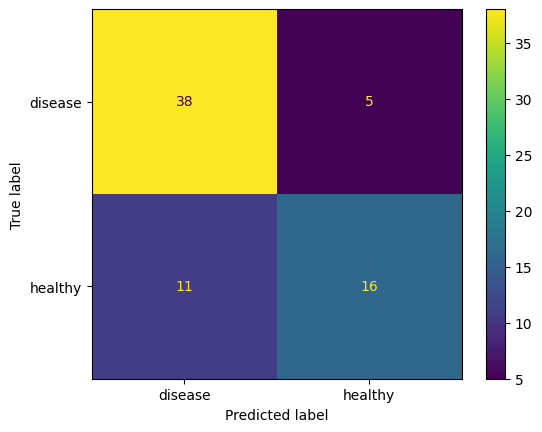

In [10]:
# Utvärdera modellen på testdata
y_pred_categorical = model.predict(X_test)
y_pred = np.argmax(y_pred_categorical, axis=1)

# Konvertera tillbaka från one-hot encoding
y_test_encoded_inverse = label_encoder.inverse_transform(y_test_encoded)
y_pred_inverse = label_encoder.inverse_transform(y_pred)

# Hämta unika klassetiketter
class_labels = np.unique(y_test_encoded_inverse)

# Utvärdera modellen
accuracy = accuracy_score(y_test_encoded_inverse, y_pred_inverse)
print(f"Accuracy: {accuracy}")

# Visa annan utvärderingsinformation
print(classification_report(y_test_encoded_inverse, y_pred_inverse))

# Skapa förvirringsmatris med klassetiketter
cm = confusion_matrix(y_test_encoded_inverse, y_pred_inverse, labels=class_labels)

# Visa förvirringsmatris med klassetiketter
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()
plt.show()


In [11]:
def random_image(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

    if not image_files:
        print("Inga bilder hittades i mappen.")
        return None

    random_image = random.choice(image_files)

    img_path = os.path.join(folder_path, random_image)

    return img_path

./dataset/YOLOstacked/images/Healthy_Fish_48.jpg
1/1 [==============================] - 0s 14ms/step
Predicted Class: Diseased
Confidence Score: 0.9999980926513672


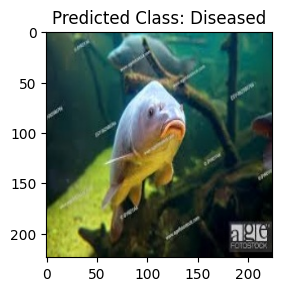

In [38]:
folder_path = './dataset/YOLOstacked/images/'
test_image_path = random_image(folder_path)
print(test_image_path)
test_image = prepare_images([test_image_path])
prediction = model.predict(test_image)

predicted_class_index = np.argmax(prediction[0])
confidence_score = prediction[0][predicted_class_index]

class_labels = ["Diseased", "Healthy"]
predicted_class_label = class_labels[predicted_class_index]

print(f"Predicted Class: {predicted_class_label}")
print(f"Confidence Score: {confidence_score}")

original_image = io.imread(test_image_path)

plt.subplot(1, 2, 2)
plt.imshow(original_image)
plt.title(f'Predicted Class: {predicted_class_label}')

plt.show()

In [13]:
test_folder_path = './dataset/test_img/Healthy_fishies/'

# Dictionary för att lagra noggrannheter per undermapp
accuracy_per_class = {}

# Loopa igenom varje undermapp i testmappen
for subdir, dirs, files in os.walk(test_folder_path):
    # Ignorera rotmappen
    if subdir == test_folder_path:
        continue

    # Lista för att lagra sanna klasser och förutsagda klasser för den aktuella undermappen
    true_labels = []
    predicted_labels = []

    for file in files:
        # Skapa den fullständiga sökvägen till varje bild
        img_path = os.path.join(subdir, file)
        test_image = prepare_images([img_path])

        # Gör prediktion med modellen
        prediction = model.predict(test_image)

        # Bestäm sann klass från undermappens namn
        true_class = os.path.basename(subdir)

        # Bestäm förutsagd klass och spara i listor
        predicted_class_index = np.argmax(prediction[0])
        class_labels = ["Diseased", "Healthy"]
        predicted_class_label = class_labels[predicted_class_index]

        true_labels.append('Healthy')
        predicted_labels.append(predicted_class_label)

    # Beräkna noggrannhet för den aktuella undermappen
    accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
    accuracy_per_class[true_class] = accuracy

1/1 [==============================] - 0s 14ms/step


In [14]:
# Skriv ut noggrannhet per undermapp
for class_name, accuracy in accuracy_per_class.items():
    print(f"Noggrannhet för {class_name}: {accuracy * 100:.2f}%")

Noggrannhet för Black Sea Sprat: 12.50%
Noggrannhet för Gilt-Head Bream: 17.31%
Noggrannhet för Hourse Mackerel: 2.27%
Noggrannhet för Red Mullet: 9.09%
Noggrannhet för Red Sea Bream: 34.78%
Noggrannhet för Sea Bass: 7.89%
Noggrannhet för Striped Red Mullet: 17.50%


In [15]:
# model.save('./saved_models/cnn_model_cropped_more_data_23-1-24.h5')

In [16]:
# loaded_model = load_model('./saved_models/cnn_model_original_data_10-1-24.h5')